In [4]:
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import gc
RANDOM_SEED=42

## Get Data

In [5]:
join_raw = pd.read_csv("Data/joined_data.csv",
                       error_bad_lines=False, 
                       index_col=False, 
                       dtype='unicode', 
                       keep_default_na=False)
join_raw.drop("parcelid",axis=1, inplace=True)

In [6]:
join_raw.head()

,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,0.0276,2016-08-02,1,,,3.0,4.0,,4,3.0,...,,,245180.0,567112.0,2015,321932.0,7219.18,,,60371132321020
1,-0.0182,2016-08-02,1,,,3.0,3.0,,4,3.0,...,,,254691.0,459844.0,2015,205153.0,6901.09,,,60371132321019
2,-0.1009,2016-05-03,1,,,2.0,3.0,,4,2.0,...,,,235114.0,384787.0,2015,149673.0,4876.61,,,60371132321020
3,-0.0121,2016-04-05,1,,,2.0,4.0,,4,2.0,...,,,262309.0,437176.0,2015,174867.0,5560.07,,,60371132321020
4,-0.0481,2016-07-15,1,,,2.0,4.0,,4,2.0,...,,,232037.0,382055.0,2015,150018.0,4878.25,,,60371132321007


## Format Data

### First : In good format

In [7]:
join_raw=join_raw.apply(pd.to_numeric, errors='ignore')

# Three boolean variables
join_raw["hashottuborspa"]=join_raw["hashottuborspa"].astype('bool')
join_raw["fireplaceflag"]=join_raw["fireplaceflag"].astype('bool')
join_raw["taxdelinquencyflag"]=join_raw["taxdelinquencyflag"].astype('bool')

# Two string variables 
join_raw["propertycountylandusecode"]=join_raw["propertycountylandusecode"].astype(str)
join_raw["propertyzoningdesc"]=join_raw["propertyzoningdesc"].astype(str)

### Second : Transform date

In [8]:
join_raw['transactiondate'] = join_raw['transactiondate'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d"))
join_raw['transactiondate'+"_date"] = [d.date() for d in join_raw['transactiondate']]
join_raw['transactiondate'+'_weekdays'] = [d.strftime('%a') for d in join_raw['transactiondate']]
join_raw = pd.concat([join_raw,pd.get_dummies(join_raw['transactiondate'+'_weekdays'])], axis=1)
join_raw.drop('transactiondate'+'_weekdays', axis=1,inplace=True)

In [9]:
#join_raw=join_raw.apply(pd.to_numeric, errors='ignore')

## Do clustering

In [10]:
from sklearn.cluster import MiniBatchKMeans

In [11]:
ms = MiniBatchKMeans(n_clusters=25, init='k-means++')

In [12]:
ms.fit(join_raw.loc[:, ['longitude', 'latitude']].as_matrix())
join_raw['cl1'] = ms.labels_

C:\Users\mlabarrere\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


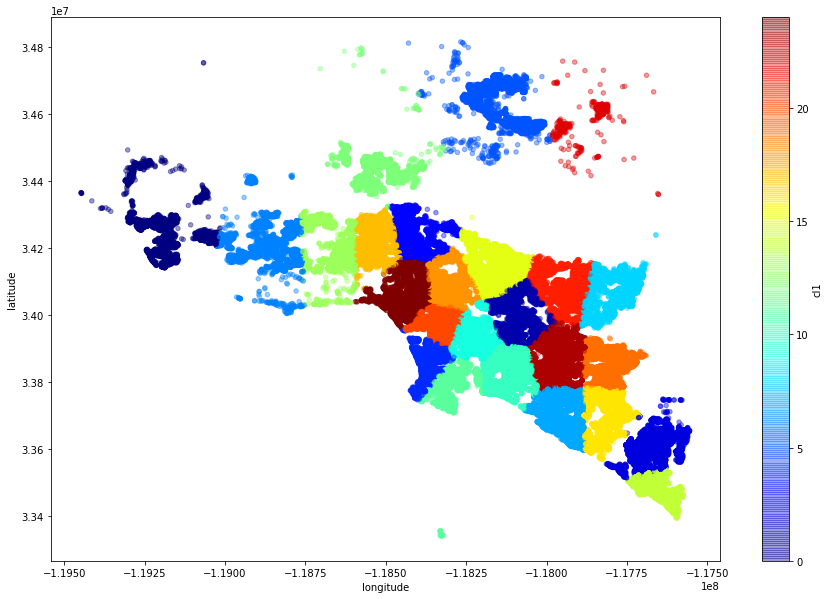

In [13]:
join_raw.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    figsize=(15,10),
    c="cl1", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

## Select and drop columns

In [14]:
join_raw=join_raw.select_dtypes(include=['int64','float64'])

In [15]:
join_raw.dropna(axis=1, 
                how='any', 
                thresh=70000, 
                subset=None, 
                inplace=True)

In [16]:
join_raw.head()

,logerror,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,...,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,0.0276,3.0,4.0,3.0,2538.0,2538.0,6037,3.0,34220381,-118620802,...,3101,96339.0,0.0,1978.0,245180.0,567112.0,2015,321932.0,7219.18,6.037113e+13
1,-0.0182,3.0,3.0,3.0,1589.0,1589.0,6037,3.0,34222040,-118622240,...,3101,96339.0,0.0,1959.0,254691.0,459844.0,2015,205153.0,6901.09,6.037113e+13
2,-0.1009,2.0,3.0,2.0,2411.0,2411.0,6037,2.0,34220427,-118618549,...,3101,96339.0,0.0,1973.0,235114.0,384787.0,2015,149673.0,4876.61,6.037113e+13
3,-0.0121,2.0,4.0,2.0,2232.0,2232.0,6037,2.0,34222390,-118618631,...,3101,96339.0,0.0,1973.0,262309.0,437176.0,2015,174867.0,5560.07,6.037113e+13
4,-0.0481,2.0,4.0,2.0,1882.0,1882.0,6037,2.0,34222544,-118617961,...,3101,96339.0,0.0,1973.0,232037.0,382055.0,2015,150018.0,4878.25,6.037113e+13


## Fill with median all missing values

In [17]:
def medianFiller(data_df):
    # Create a median inputer
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    return pd.DataFrame(imp.fit_transform(data_df),columns=data_df.columns.values)

In [18]:
join_raw=medianFiller(join_raw)

## Drop 90% of data... Low memory laptop :(

In [19]:
join_raw=join_raw.sample(n=None, 
                         frac=0.2, 
                         replace=True, 
                         weights=None, 
                         random_state=RANDOM_SEED, 
                         axis=None
                        )

## Divide everything by everything

In [ ]:
nbcol=join_raw.shape[1]
for col1 in range(1, nbcol):
    for col2 in range(col1+1,nbcol):
        col1_name=str(join_raw[[col1]].columns.values[0])
        col2_name=str(join_raw[[col2]].columns.values[0])
        new_col=col1_name+"_per_"+col2_name
        print(new_col)
        if join_raw[col2_name].any() == 0:
            join_raw[str(new_col)]=float('nan')
        else:
            join_raw[str(new_col)]=(join_raw[col1_name]/join_raw[col2_name])

In [ ]:
join_raw.head()

## Remplace inf values with median

In [ ]:
join_raw=join_raw.replace([np.inf, -np.inf], np.nan)
join_raw=medianFiller(join_raw)

## Create test and train set

In [20]:
train_set, test_set = train_test_split(join_raw, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED)
del join_raw
gc.collect()

354

## Remove logerror outliers

In [21]:
logerror_avg = train_set['logerror'].mean()
logerror_std = train_set['logerror'].std()

train_set_outliers=train_set.where((train_set["logerror"] < logerror_avg - 2*logerror_std) & 
                            (train_set["logerror"] > logerror_avg + 2*logerror_std)
                           )

In [22]:
train_set=train_set.where((train_set["logerror"] >= logerror_avg - 2*logerror_std) & 
                            (train_set["logerror"] <= logerror_avg + 2*logerror_std)
                           )

In [23]:
train_set.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)

## Create train and test sets

In [24]:
Y_train=train_set["logerror"]
X_train=train_set.drop(["logerror"],axis=1,inplace=False)
Y_test=test_set["logerror"]
X_test=test_set.drop(["logerror"],axis=1,inplace=False)

In [25]:
del train_set_outliers
del train_set
del test_set
del logerror_avg
del logerror_std
gc.collect()

24

# Models

In [ ]:
to_drop=["bathroomcnt", "bedroomcnt", "calculatedbathnbr", "calculatedfinishedsquarefeet", "finishedsquarefeet12", "fips", "fullbathcnt", "latitude", "longitude", "lotsizesquarefeet", "propertylandusetypeid", "rawcensustractandblock", "regionidcity", "regionidcounty", "regionidzip", "roomcnt", "yearbuilt", "structuretaxvaluedollarcnt", "taxvaluedollarcnt", "assessmentyear", "landtaxvaluedollarcnt", "censustractandblock", "bathroomcnt_per_bedroomcnt", "bathroomcnt_per_calculatedbathnbr", "bathroomcnt_per_calculatedfinishedsquarefeet", "bathroomcnt_per_finishedsquarefeet12", "bathroomcnt_per_fullbathcnt", "bathroomcnt_per_latitude", "bathroomcnt_per_longitude", "bathroomcnt_per_lotsizesquarefeet", "bathroomcnt_per_propertylandusetypeid", "bathroomcnt_per_rawcensustractandblock", "bathroomcnt_per_regionidcity", "bathroomcnt_per_regionidcounty", "bathroomcnt_per_regionidzip", "bathroomcnt_per_yearbuilt", "bathroomcnt_per_taxvaluedollarcnt", "bathroomcnt_per_assessmentyear", "bathroomcnt_per_landtaxvaluedollarcnt", "bathroomcnt_per_taxamount", "bathroomcnt_per_censustractandblock", "bedroomcnt_per_calculatedbathnbr", "bedroomcnt_per_fips", "bedroomcnt_per_fullbathcnt", "bedroomcnt_per_latitude", "bedroomcnt_per_longitude", "bedroomcnt_per_lotsizesquarefeet", "bedroomcnt_per_propertylandusetypeid", "bedroomcnt_per_rawcensustractandblock", "bedroomcnt_per_regionidcity", "bedroomcnt_per_regionidcounty", "bedroomcnt_per_regionidzip", "bedroomcnt_per_yearbuilt", "bedroomcnt_per_structuretaxvaluedollarcnt", "bedroomcnt_per_taxvaluedollarcnt", "bedroomcnt_per_assessmentyear", "bedroomcnt_per_landtaxvaluedollarcnt", "bedroomcnt_per_taxamount", "bedroomcnt_per_censustractandblock", "calculatedbathnbr_per_calculatedfinishedsquarefeet", "calculatedbathnbr_per_finishedsquarefeet12", "calculatedbathnbr_per_fips", "calculatedbathnbr_per_fullbathcnt", "calculatedbathnbr_per_latitude", "calculatedbathnbr_per_longitude", "calculatedbathnbr_per_lotsizesquarefeet", "calculatedbathnbr_per_propertylandusetypeid", "calculatedbathnbr_per_rawcensustractandblock", "calculatedbathnbr_per_regionidcity", "calculatedbathnbr_per_regionidcounty", "calculatedbathnbr_per_regionidzip", "calculatedbathnbr_per_roomcnt", "calculatedbathnbr_per_structuretaxvaluedollarcnt", "calculatedbathnbr_per_taxvaluedollarcnt", "calculatedbathnbr_per_assessmentyear", "calculatedbathnbr_per_landtaxvaluedollarcnt", "calculatedbathnbr_per_taxamount", "calculatedbathnbr_per_censustractandblock", "calculatedfinishedsquarefeet_per_finishedsquarefeet12", "calculatedfinishedsquarefeet_per_fips", "calculatedfinishedsquarefeet_per_fullbathcnt", "calculatedfinishedsquarefeet_per_longitude", "calculatedfinishedsquarefeet_per_lotsizesquarefeet", "calculatedfinishedsquarefeet_per_propertylandusetypeid", "calculatedfinishedsquarefeet_per_rawcensustractandblock", "calculatedfinishedsquarefeet_per_regionidcity", "calculatedfinishedsquarefeet_per_regionidcounty", "calculatedfinishedsquarefeet_per_structuretaxvaluedollarcnt", "calculatedfinishedsquarefeet_per_taxvaluedollarcnt", "calculatedfinishedsquarefeet_per_landtaxvaluedollarcnt", "calculatedfinishedsquarefeet_per_censustractandblock", "finishedsquarefeet12_per_fips", "finishedsquarefeet12_per_fullbathcnt", "finishedsquarefeet12_per_latitude", "finishedsquarefeet12_per_longitude", "finishedsquarefeet12_per_lotsizesquarefeet", "finishedsquarefeet12_per_propertylandusetypeid", "finishedsquarefeet12_per_rawcensustractandblock", "finishedsquarefeet12_per_regionidcounty", "finishedsquarefeet12_per_regionidzip", "finishedsquarefeet12_per_yearbuilt", "finishedsquarefeet12_per_structuretaxvaluedollarcnt", "finishedsquarefeet12_per_taxvaluedollarcnt", "finishedsquarefeet12_per_assessmentyear", "finishedsquarefeet12_per_landtaxvaluedollarcnt", "finishedsquarefeet12_per_censustractandblock", "fips_per_latitude", "fips_per_longitude", "fips_per_lotsizesquarefeet", "fips_per_propertylandusetypeid", "fips_per_rawcensustractandblock", "fips_per_regionidcity", "fips_per_regionidcounty", "fips_per_regionidzip", "fips_per_roomcnt", "fips_per_yearbuilt", "fips_per_structuretaxvaluedollarcnt", "fips_per_taxvaluedollarcnt", "fips_per_assessmentyear", "fips_per_landtaxvaluedollarcnt", "fips_per_taxamount", "fips_per_censustractandblock", "fullbathcnt_per_latitude", "fullbathcnt_per_longitude", "fullbathcnt_per_lotsizesquarefeet", "fullbathcnt_per_propertylandusetypeid", "fullbathcnt_per_rawcensustractandblock", "fullbathcnt_per_regionidcity", "fullbathcnt_per_regionidcounty", "fullbathcnt_per_regionidzip", "fullbathcnt_per_roomcnt", "fullbathcnt_per_yearbuilt", "fullbathcnt_per_structuretaxvaluedollarcnt", "fullbathcnt_per_taxvaluedollarcnt", "fullbathcnt_per_assessmentyear", "fullbathcnt_per_landtaxvaluedollarcnt", "fullbathcnt_per_taxamount", "fullbathcnt_per_censustractandblock", "latitude_per_longitude", "latitude_per_lotsizesquarefeet", "latitude_per_rawcensustractandblock", "latitude_per_regionidcity", "latitude_per_regionidzip", "latitude_per_roomcnt", "latitude_per_structuretaxvaluedollarcnt", "latitude_per_assessmentyear", "latitude_per_landtaxvaluedollarcnt", "latitude_per_taxamount", "latitude_per_censustractandblock", "longitude_per_lotsizesquarefeet", "longitude_per_rawcensustractandblock", "longitude_per_regionidcounty", "longitude_per_yearbuilt", "longitude_per_structuretaxvaluedollarcnt", "longitude_per_taxvaluedollarcnt", "longitude_per_assessmentyear", "longitude_per_landtaxvaluedollarcnt", "longitude_per_taxamount", "longitude_per_censustractandblock", "lotsizesquarefeet_per_propertylandusetypeid", "lotsizesquarefeet_per_rawcensustractandblock", "lotsizesquarefeet_per_regionidcity", "lotsizesquarefeet_per_regionidcounty", "lotsizesquarefeet_per_regionidzip", "lotsizesquarefeet_per_yearbuilt", "lotsizesquarefeet_per_assessmentyear", "lotsizesquarefeet_per_landtaxvaluedollarcnt", "lotsizesquarefeet_per_censustractandblock", "propertylandusetypeid_per_rawcensustractandblock", "propertylandusetypeid_per_regionidcity", "propertylandusetypeid_per_regionidzip", "propertylandusetypeid_per_roomcnt", "propertylandusetypeid_per_yearbuilt", "propertylandusetypeid_per_taxvaluedollarcnt", "propertylandusetypeid_per_assessmentyear", "propertylandusetypeid_per_landtaxvaluedollarcnt", "propertylandusetypeid_per_taxamount", "propertylandusetypeid_per_censustractandblock", "rawcensustractandblock_per_regionidcity", "rawcensustractandblock_per_regionidcounty", "rawcensustractandblock_per_roomcnt", "rawcensustractandblock_per_yearbuilt", "rawcensustractandblock_per_structuretaxvaluedollarcnt", "rawcensustractandblock_per_assessmentyear", "rawcensustractandblock_per_landtaxvaluedollarcnt", "rawcensustractandblock_per_taxamount", "rawcensustractandblock_per_censustractandblock", "regionidcity_per_regionidcounty", "regionidcity_per_regionidzip", "regionidcity_per_roomcnt", "regionidcity_per_yearbuilt", "regionidcity_per_taxvaluedollarcnt", "regionidcity_per_assessmentyear", "regionidcity_per_landtaxvaluedollarcnt", "regionidcity_per_taxamount", "regionidcity_per_censustractandblock", "regionidcounty_per_yearbuilt", "regionidcounty_per_structuretaxvaluedollarcnt", "regionidcounty_per_taxvaluedollarcnt", "regionidcounty_per_assessmentyear", "regionidcounty_per_taxamount", "regionidzip_per_roomcnt", "regionidzip_per_yearbuilt", "regionidzip_per_structuretaxvaluedollarcnt", "regionidzip_per_taxvaluedollarcnt", "regionidzip_per_assessmentyear", "regionidzip_per_landtaxvaluedollarcnt", "regionidzip_per_taxamount", "regionidzip_per_censustractandblock", "roomcnt_per_yearbuilt", "roomcnt_per_structuretaxvaluedollarcnt", "roomcnt_per_taxvaluedollarcnt", "roomcnt_per_assessmentyear", "roomcnt_per_landtaxvaluedollarcnt", "roomcnt_per_taxamount", "roomcnt_per_censustractandblock", "yearbuilt_per_structuretaxvaluedollarcnt", "yearbuilt_per_taxvaluedollarcnt", "yearbuilt_per_assessmentyear", "yearbuilt_per_landtaxvaluedollarcnt", "yearbuilt_per_taxamount", "yearbuilt_per_censustractandblock", "structuretaxvaluedollarcnt_per_taxvaluedollarcnt", "structuretaxvaluedollarcnt_per_assessmentyear", "structuretaxvaluedollarcnt_per_landtaxvaluedollarcnt", "structuretaxvaluedollarcnt_per_censustractandblock", "taxvaluedollarcnt_per_assessmentyear", "taxvaluedollarcnt_per_landtaxvaluedollarcnt", "taxvaluedollarcnt_per_censustractandblock", "assessmentyear_per_landtaxvaluedollarcnt", "assessmentyear_per_taxamount", "assessmentyear_per_censustractandblock", "landtaxvaluedollarcnt_per_censustractandblock", "taxamount_per_censustractandblock"]

In [ ]:
X_train.drop(to_drop,axis=1,inplace=True)
X_test.drop(to_drop,axis=1,inplace=True)

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gb_rg = GradientBoostingRegressor(loss='huber', 
                                  learning_rate=0.1, 
                                  n_estimators=10, 
                                  subsample=1.0, 
                                  criterion='mae', 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_depth=3, 
                                  min_impurity_split=1e-07, 
                                  init=None, 
                                  random_state=RANDOM_SEED, 
                                  max_features=None, 
                                  alpha=0.9, 
                                  verbose=3, 
                                  max_leaf_nodes=None, 
                                  warm_start=False, 
                                  presort='auto'
                                 )

In [ ]:
gb_rg.fit(X_train, Y_train)

In [ ]:
y_pred_gb = gb_rg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test, y_pred_gb)

In [ ]:
for name, score in zip(X_train.columns.values,gb_rg.feature_importances_):
    print(name,score)